In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [22]:
from retina.data.widerface import WiderFaceCustomDataset
from retina import transforms as CT
from torchvision import transforms as T

from torch.utils.data import DataLoader
from retina.data.widerface import detection_collate

from retina.ops.nms import py_cpu_nms
import numpy as np

from retina.models.retina import RetinaFace
from retina.data import config
from retina.modules.prior_box import PriorBox, CustomPriorBox
from retina.ops.boxes import decode, decode_landm

In [23]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [24]:
def image_preprocessing(image, img_size=(640,640)):
    img = np.float32(image)
    img = cv2.resize(img, img_size, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
    im_height, im_width, _ = img.shape
    
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    scale = scale.to(device)

    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    
    return img, scale 


def get_prior_box_data(image_size, min_sizes=None, steps=None, clip=False, device="cpu"):
    priorbox = CustomPriorBox(image_size=(im_width, im_height), min_sizes=min_sizes, steps=steps, clip=clip)
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data
    return prior_data


def get_dets_from_network(predicted, image_size=(640,640), variance=(0.1, 0.2), nms_threshold=0.4,
                          top_k=5000, keep_top_k=750, confidence_threshold=0.02, ):
    
    locations, confidences, landmarks = predicted
    im_width, im_height = image_size
    prior_data = get_prior_box_data(image_size=(im_width, im_height))
    
    # boxes location
    boxes = decode(locations.data.squeeze(0), prior_data, variance)
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()

    scores = confidences.squeeze(0).data.cpu().numpy()[:, 1]
    landmarks = decode_landm(landmarks.data.squeeze(0), prior_data, variance)

    scale1 = torch.Tensor([
        im_width, im_height, im_width, im_height,
        im_width, im_height, im_width, im_height,
        im_width, im_height
    ])

    scale1 = scale1.to(device)
    landmarks = landmarks * scale1 / resize
    landmarks = landmarks.cpu().numpy()

    # ignore low scores
    indices = np.where(scores > confidence_threshold)[0]
    boxes, landmarks, scores = boxes[indices], landmarks[indices], scores[indices]

    # keep top-K before NMS
    order = scores.argsort()[::-1][:top_k]
    boxes, landmarks, scores = boxes[order], landmarks[order], scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, nms_threshold)
    # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
    dets = dets[keep, :]
    landmarks = landmarks[keep]

    # keep top-K faster NMS
    dets = dets[:keep_top_k, :]
    landmarks = landmarks[:keep_top_k, :]

    dets = np.concatenate((dets, landmarks), axis=1)
    return dets

def draw_face_landmark(image, dets):
    img_raw = image.copy()
    for b in dets:
        if b[4] < vis_thres:
            continue
        text = "{:.4f}".format(b[4])
        b = list(map(int, b))
        cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
        cx = b[0]
        cy = b[1] + 12
        cv2.putText(img_raw, text, (cx, cy), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

        # landms
        cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4)
        cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4)
        cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4)
        cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
        cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4)
        
    return img_raw

In [36]:
device = "cpu"

im_width, im_height = img_dim = (640, 640)
rgb_means = (104, 117, 123)
resize = 1

top_k=5000
keep_top_k = 750
confidence_threshold=0.02
nms_threshold=0.4
vis_thres=0.6


In [37]:
root = '/data/widerface/custom_dataset/train/'
dataset_tmft = WiderFaceCustomDataset(root=root, pair_transform=CT.Preprocess(img_dim=640, rgb_means=(104, 117, 123)))
dataset = WiderFaceCustomDataset(root=root)

In [128]:
image, target = dataset[45]
img_prep, scale = image_preprocessing(image)

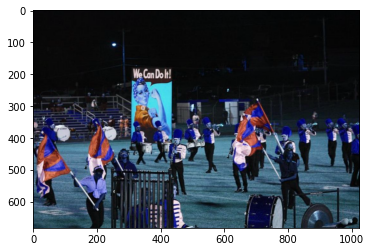

In [129]:
plt.imshow(image)

In [130]:
rface = RetinaFace(cfg=config.cfg_re50, phase="test")
rface.eval()
print()

pretrained_path = '../weights/Resnet50_Final.pth'
rface = load_model(rface, pretrained_path, load_to_cpu=True)
rface = rface.to(device)
rface.eval()
print()


Loading pretrained model from ../weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456



In [131]:
locations, confidences, landmarks = predicted = rface(img_prep)

In [132]:
locations.shape, confidences.shape, landmarks.shape

(torch.Size([1, 16800, 4]),
 torch.Size([1, 16800, 2]),
 torch.Size([1, 16800, 10]))

In [133]:
img_raw = np.array(image)
img_raw = cv2.resize(img_raw, (640, 640), None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)

In [134]:
dets = get_dets_from_network(predicted)
img_raw = draw_face_landmark(img_raw, dets)

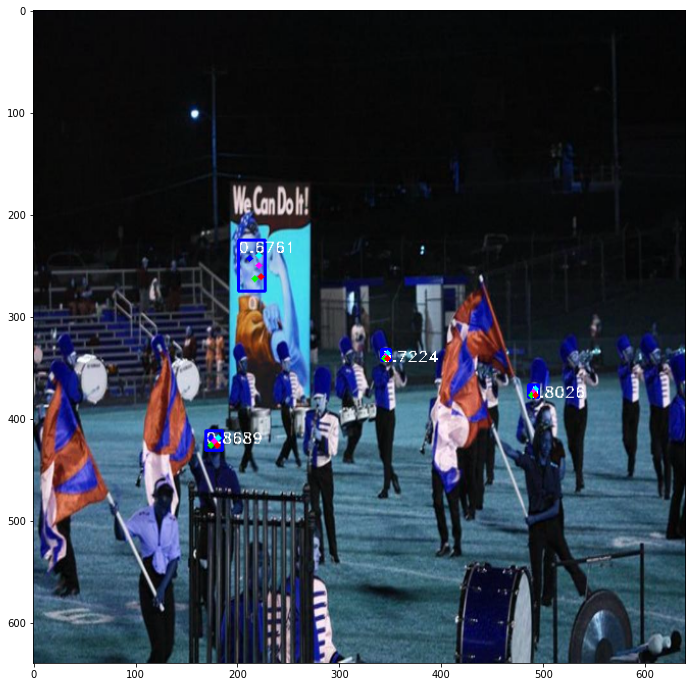

In [135]:
plt.figure(figsize=(12,12))
plt.imshow(img_raw)